<a href="https://colab.research.google.com/github/hisunnytang/PolHole-code/blob/master/ts_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
import matplotlib.pyplot as plt


# Irregular Time Series AutoEncoder!

https://github.com/bnaul/IrregularTimeSeriesAutoencoderPaper/blob/master/autoencoder.py




In [0]:
import numpy as np
np.random.seed(0)
from tensorflow.keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout,
                          Flatten, RepeatVector, Bidirectional, SimpleRNN, Concatenate)
# merge, recurrent does not exist in tf2.0
# merge is replaced with concatenate
from tensorflow.keras.models import Model


In [0]:
def encoder(model_input, layer,size , num_layers, drop_frac = 0.0 , 
            output_size=None, bidirectional=False, **parsed_args):
    """Encoder module of autoencoder architecture.
    Can be used either as the encoding component of an autoencoder or as a standalone
    encoder, which takes (possibly irregularly-sampled) time series as inputs and produces
    a fixed-length vector as output.
    model_input: `keras.layers.Input`
        Input layer containing (y) or (dt, y) values
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    output_size: int, optional
        Size of encoding layer; defaults to `size`
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """

    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

In [0]:
def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.0, aux_input=None,
            bidirectional=False, **parsed_args):
    """Decoder module of autoencoder architecture.
    Can be used either as the decoding component of an autoencoder or as a standalone
    decoder, which takes a fixed-length input vector and generates a length-`n_step`
    time series as output.
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    n_step: int
        Length of output time series
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    aux_input: `keras.layers.Input`, optional
        Input layer containing `dt` values; if `None` then the sequence is assumed to be
        evenly-sampled
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = Concatenate(axis=-1)([aux_input, decode])

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

In [0]:
from absl import flags

for name in list(flags.FLAGS):
  delattr(flags.FLAGS, name)

# enc_type = flags["enc_type"].value
# enc_emb_size   = flags["enc_emb_size"].value
# enc_outsize = flags["enc_out_size"].value
# enc_layers  = flags["enc_num_layers"].values
# dropout     = flags["dropout_frac"].values


flags.DEFINE_string("enc_type", "GRU", "Encoder RNN-type")
flags.DEFINE_integer("enc_emb_size", 32, "Hidden units of the encoder RNN cells")
flags.DEFINE_integer("enc_out_size", 32, "encoder output size")
flags.DEFINE_integer("enc_num_layers", 4, "Number of stacked layers of RNNs")
flags.DEFINE_float("dropout_frac", 0.1, "Dropout Fraction")

flags.DEFINE_integer("dec_num_layers", 4, 
                     "Number of stacked layers of RNNs in the decoder")
flags.DEFINE_string("dec_type", "GRU", "Decoder RNN-type")
flags.DEFINE_integer("dec_emb_size", 32, 
                     "Hidden units of the decoder RNN cells" )

flags.DEFINE_integer("NTIME", 100, "maximum data points on the time axes")
flags.DEFINE_integer("NFEAT", 2, "number of feature of the time series (including the time axis)")

FLAGS = flags.FLAGS

In [0]:
# input layers
# X[NDATA, Ntime, Nfeat]

NTIME = FLAGS["NTIME"].value
NFEAT = FLAGS["NFEAT"].value

main_input = Input(shape=(NTIME, NFEAT), name='main_input')
aux_input = Input(shape=(NTIME, NFEAT - 1), name='aux_input')


In [0]:
enc_type = FLAGS["enc_type"].value
enc_emb_size   = FLAGS["enc_emb_size"].value
enc_outsize = FLAGS["enc_out_size"].value
enc_layers  = FLAGS["enc_num_layers"].value
dropout     = FLAGS["dropout_frac"].value

model_type_dict = {'GRU': GRU, 'lstm': LSTM, 'vanilla': SimpleRNN}
enc_type = model_type_dict[enc_type]

encode = encoder(main_input, 
                 layer = enc_type,
                 size = enc_emb_size,
                 output_size= enc_outsize, 
                 num_layers = enc_layers, 
                 drop_frac = dropout)

In [0]:
dec_layers = FLAGS["dec_num_layers"].value
dec_type = FLAGS["dec_type"].value


dec_type = model_type_dict[dec_type]
dec_emb_size = FLAGS["dec_emb_size"].value

decode = decoder(encode, 
                 layer= dec_type,
                 n_step=NTIME, 
                 size = dec_emb_size,
                 num_layers=dec_layers,
                 drop_frac = dropout,
                 aux_input=aux_input)

In [0]:
model_input = [main_input, aux_input]
model = Model(model_input, decode)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
encode_0 (GRU)                  (None, 100, 32)      3456        main_input[0][0]                 
__________________________________________________________________________________________________
drop_encode_0 (Dropout)         (None, 100, 32)      0           encode_0[0][0]                   
__________________________________________________________________________________________________
encode_1 (GRU)                  (None, 100, 32)      6336        drop_encode_0[0][0]              
______________________________________________________________________________________________

# Example Data!

In [0]:
# generate datasets
import numpy as np

# let's just start with a simple sine curve
# with lags distributed according to pareto distribution

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def phase_to_sin_cos(Y):
    """Reparametrize sinusoid parameters:
        w, A, phi, b --> p, A_cos, A_sin, b
    Estimating these parameters seems to be easier in practice.
    """
    w, A, phi, b = Y.T

    A_cos = A * np.sin(phi)
    A_sin = A * np.cos(phi)
    p = w ** -1

    return np.c_[p, A_cos, A_sin, b]


def _random_times(N, even=True, t_max=4 * np.pi, n_min=None, n_max=None, t_shape=2, t_scale=0.05):
    if n_min is None and n_max is None:
        raise ValueError("Either n_min or n_max is required.")
    elif n_min is None:
        n_min = n_max
    elif n_max is None:
        n_max = n_min

    if even:
        return np.tile(np.linspace(0., t_max, n_max), (N, 1))
    else:
        lags = [t_scale * np.random.pareto(t_shape, size=np.random.randint(n_min, n_max + 1))
                for i in range(N)]
        return [np.r_[0, np.cumsum(lags_i)] for lags_i in lags]


def _periodic_params(N, A_min, A_max, w_min, w_max):
    w = 1. / np.random.uniform(1. / w_max, 1. / w_min, size=N)
    A = np.random.uniform(A_min, A_max, size=N)
    phi = 2 * np.pi * np.random.random(size=N)
    b = np.random.normal(scale=1, size=N)

    return w, A, phi, b


def _sinusoid(w, A, phi, b):
    return lambda t: A * np.sin(2 * np.pi * w * t + phi) + b


def periodic(N, n_min, n_max, t_max=4 * np.pi, even=True, A_min=0.5, A_max=2.0,
             noise_sigma=0., w_min=0.1, w_max=1., t_shape=2, t_scale=0.05,
             kind='sinusoid'):
    """Returns periodic data (values, (freq, amplitude, phase, offset))"""
    t = _random_times(N, even, t_max, n_min, n_max, t_shape, t_scale)
    w, A, phi, b = _periodic_params(N, A_min, A_max, w_min, w_max)

    X_list = [np.c_[t[i], _sinusoid(w[i], A[i], phi[i], b[i])(t[i])] for i in range(N)]
    X_raw = pad_sequences(X_list, maxlen=n_max, value=np.nan, dtype='float', padding='post')
    X = X_raw.copy()
    X[:, :, 1] = X_raw[:, :, 1] + np.random.normal(scale=noise_sigma + 1e-9, size=(N, n_max))
    Y = np.c_[w, A, phi, b]
    
    return X, Y, X_raw

In [0]:
NDATA = 10000

n_min = 64
n_max = 96

X,Y, X_raw = periodic(N = NDATA, 
                      n_min = 10, 
                      n_max = 100, 
                      t_max=4 * np.pi, 
                      even=False, 
                      A_min=0.5, A_max=2.0,
                      noise_sigma=0.3, 
                      w_min=0.1, w_max=1.0, t_shape=2, t_scale=0.5,
                      kind='sinusoid')


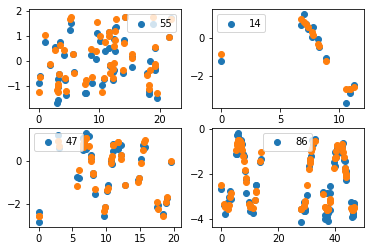

In [0]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flatten()):
  n_nan = (~np.isnan(X[i, :, 1])).sum()
  ax.scatter(X[i, :, 0], X[i, :, 1], label = str(n_nan))
  ax.scatter(X_raw[i, :, 0], X_raw[i, :, 1])
  ax.legend()

In [0]:
from tensorflow.keras.optimizers import Adam

train_split = 0.8
N_train = int(train_split *NDATA)
N_test = NDATA - N_train

train = np.arange(N_train)
test = np.arange(N_test) + N_train

finetune_rate = 1.0e-3
optimizer = Adam(lr=lr if not finetune_rate else finetune_rate)

sample_weight = (X[train, :, -1] != -1)

loss = 'mse'
metrics = []
model.compile(optimizer=optimizer, loss=loss, metrics=metrics,
              sample_weight_mode='temporal' if sample_weight is not None else None)

In [0]:
X_train = X[train]
Xraw_train = X_raw[train]

X_test = X_raw[test]
Xraw_test = X_raw[test]

def times_to_lags(T):
    """(N x n_step) matrix of times -> (N x n_step) matrix of lags.
    First time is assumed to be zero.
    """
    assert T.ndim == 2, "T must be an (N x n_step) matrix"
    return np.c_[np.diff(T, axis=1), np.zeros(T.shape[0])]

X_train[:, :, 0] = times_to_lags(Xraw_train[:, :, 0])
X_train[np.isnan(X_train)] = -1.
Xraw_train[np.isnan(Xraw_train)] = -1.


X_test[:, :, 0] = times_to_lags(X_test[:, :, 0])
X_test[np.isnan(X_test)] = -1.

In [0]:
input_data = [X_train, X_train[:,:,0:1]]
test_data = [X_test, X_test[:,:,0:1]]

In [0]:
from keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
import csv
from collections import Iterable, OrderedDict
import datetime

class TimedCSVLogger(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if not self.writer:
            self.keys = sorted(logs.keys())

            class CustomDialect(csv.excel):
                delimiter = self.sep

            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['epoch', 'time'] + self.keys,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = OrderedDict({'epoch': epoch, 'time': str(datetime.datetime.now())})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()

In [0]:
model

In [0]:
csv_logger = tf.keras.callbacks.CSVLogger("training.csv", separator=',')
history = model.fit(input_data, Xraw_train[:,:,1:2], 
                    epochs = 100, verbose=2, validation_split= 0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 - 8s - loss: 0.4648 - val_loss: 0.4548
Epoch 2/100
6400/6400 - 7s - loss: 0.4626 - val_loss: 0.4482
Epoch 3/100
6400/6400 - 7s - loss: 0.4595 - val_loss: 0.4455
Epoch 4/100
6400/6400 - 8s - loss: 0.4545 - val_loss: 0.4369
Epoch 5/100
6400/6400 - 7s - loss: 0.4435 - val_loss: 0.4333
Epoch 6/100
6400/6400 - 7s - loss: 0.4346 - val_loss: 0.4112
Epoch 7/100
6400/6400 - 7s - loss: 0.4286 - val_loss: 0.4083
Epoch 8/100
6400/6400 - 7s - loss: 0.4221 - val_loss: 0.3999
Epoch 9/100
6400/6400 - 7s - loss: 0.4128 - val_loss: 0.3991
Epoch 10/100
6400/6400 - 7s - loss: 0.4068 - val_loss: 0.3833
Epoch 11/100
6400/6400 - 7s - loss: 0.4016 - val_loss: 0.3827
Epoch 12/100
6400/6400 - 8s - loss: 0.3982 - val_loss: 0.3736
Epoch 13/100
6400/6400 - 7s - loss: 0.3924 - val_loss: 0.3670
Epoch 14/100
6400/6400 - 8s - loss: 0.3862 - val_loss: 0.3596
Epoch 15/100
6400/6400 - 8s - loss: 0.3810 - val_loss: 0.3624
Epoch 16/100
6400/6400 - 8s - l

dict_keys(['loss', 'val_loss'])


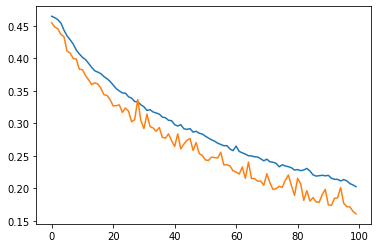

In [0]:
loss = history.history
print(loss.keys())
plt.plot(loss["loss"])
plt.plot(loss["val_loss"])

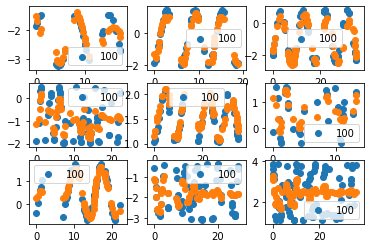

In [0]:
import matplotlib.pyplot as plt

ytest = model.predict(test_data)

f, axes = plt.subplots(3,3)
for i, ax in enumerate(axes.flatten()):

  i = np.random.randint(2000)
  n_nan = (~np.isnan(X_test[i, :, 1])).sum()
  ax.scatter(Xraw_test[i, :, 0], X_test[i, :, 1], label = str(n_nan))
  ax.scatter(Xraw_test[i, :, 0], ytest[i, :, 0])
  ax.legend()

In [0]:
np.random.randint(1000)

789

In [0]:
y.shape

(8000, 100, 1)

In [0]:
1350/870

1.5517241379310345

In [0]:
1.5/2.2

0.6818181818181818

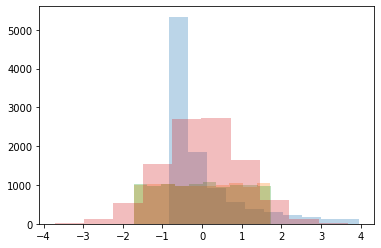

In [0]:
for i in range(4):
  plt.hist(ystand[:,i], alpha = 0.3)

In [0]:

from sklearn.preprocessing import StandardScaler

ystand = StandardScaler().fit(Y).transform(Y)

In [0]:
# Now transfer learning!

# create new model!


encode = encoder(main_input, 
                 layer = enc_type,
                 size = enc_emb_size,
                 output_size= enc_outsize, 
                 num_layers = enc_layers, 
                 drop_frac = dropout)

out = Dense(Y.shape[-1], activation='tanh')(encode)


In [0]:
model = Model([model_input], out)


In [0]:
for l in model.layers:
  print(l)

# Ingesting Lightcurve data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls gdrive/My\ Drive/mock_*


'gdrive/My Drive/mock_agn.csv'		'gdrive/My Drive/mock_lc_obs_cad2.csv'
'gdrive/My Drive/mock_lc_full_1e4.csv'	'gdrive/My Drive/mock_lc_obs_cad6.csv'
'gdrive/My Drive/mock_lc_obs_cad1.csv'


In [0]:
import pandas as pd

In [0]:
lc_cad6 = pd.read_csv("gdrive/My Drive/mock_lc_obs_cad6.csv", delimiter='\t')
agn_cat = pd.read_csv("gdrive/My Drive/mock_agn.csv", delimiter='\t')

In [5]:
agn_cat.head()

,obj_id,z,imag,logL5100,logL3000,logFWHM_hb,logMbh_hb,tau_drw,sigma_drw,lag_u,lag_g,lag_r,lag_i,lag_z,lag_y,f_u,f_g,f_r,f_i,f_z,f_y
0,0,2.013639,18.032446,46.163641,46.278865,3.726036,9.443893,733.777731,0.004432,-5.385637,0.0,7.914683,15.017492,26.047311,35.988240,5.904308e-13,5.134720e-13,4.493655e-13,4.078408e-13,3.798050e-13,3.516311e-13
1,1,0.416838,20.874157,43.577630,43.692854,3.440847,7.580508,595.915205,0.012315,-0.325256,0.0,0.479418,1.058865,1.377587,1.977531,7.229969e-14,6.287590e-14,5.502589e-14,4.994109e-14,4.650804e-14,4.305808e-14
2,2,1.209258,21.296150,44.366276,44.481500,3.304164,7.701466,125.034528,0.019955,-0.581680,0.0,0.834407,1.619880,2.474230,3.344473,3.308526e-14,2.877281e-14,2.518055e-14,2.285368e-14,2.128267e-14,1.970393e-14
3,3,2.014129,20.906063,45.014473,45.129698,3.576584,8.570405,783.469152,0.012674,-0.799882,0.0,1.061254,1.734637,2.761009,4.356872,4.185457e-14,3.639910e-14,3.185470e-14,2.891109e-14,2.692368e-14,2.492649e-14
4,4,1.356444,20.497257,44.788156,44.903380,3.376679,8.057436,304.009780,0.019299,-0.340711,0.0,0.463602,0.900704,1.653804,2.598019,6.578222e-14,5.720794e-14,5.006558e-14,4.543915e-14,4.231557e-14,3.917660e-14


In [6]:
lc_cad6.head()

,objid,time_g,time_r,time_i,time_z,time_y,f_g,f_r,f_i,f_z,f_y,f_err_g,f_err_r,f_err_i,f_err_z,f_err_y
0,0.0,2.1,1.2,8.6,2.3,4.0,5.099052e-13,4.435228e-13,4.033789e-13,3.780398e-13,3.473823e-13,4.238515e-16,4.086764e-16,6.069619e-16,1.050271e-15,2.846785e-15
1,0.0,8.6,11.7,11.9,4.7,13.3,5.108013e-13,4.473170e-13,4.007466e-13,3.811360e-13,3.462734e-13,4.238515e-16,4.086764e-16,6.069619e-16,1.050271e-15,2.846785e-15
2,0.0,19.5,17.8,16.3,18.4,14.9,5.092370e-13,4.485864e-13,4.048715e-13,3.767276e-13,3.505197e-13,4.238515e-16,4.086764e-16,6.069619e-16,1.050271e-15,2.846785e-15
3,0.0,27.1,25.4,20.8,20.9,22.6,5.160243e-13,4.448613e-13,4.077479e-13,3.751066e-13,3.419849e-13,4.238515e-16,4.086764e-16,6.069619e-16,1.050271e-15,2.846785e-15
4,0.0,29.9,29.8,30.8,31.8,30.6,5.176929e-13,4.470239e-13,4.064069e-13,3.791456e-13,3.567920e-13,4.238515e-16,4.086764e-16,6.069619e-16,1.050271e-15,2.846785e-15


In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
class lightcurve():
  def __init__(self, data, objdata, objid):
      self._lc = data.loc[data["objid"] == objid]
      self._prop = objdata.loc[objdata["obj_id"] == objid]

  def plot_full_lightcure(self, standardize = True):
    f, ax = plt.subplots()
    for b in "grizy":
      ax = self.plot_lightcure(ax, band =b, standardize=standardize)
    ax.legend()
  def plot_lightcure(self, ax, band = 'g', standardize = True):
    if band not in "grizy":
      raise NameError("band not identified")
    if standardize:
      lc = self.standardize(self._lc["f_{}".format(band)])
    else:
      lc = self._lc["f_{}".format(band)]
    t = self._lc["time_{}".format(band)]
    # ax.semilogy(t, lc, ls ='', marker ='.', label=band)
    band_lag = self._prop["lag_{}".format(band)]
    print(band_lag)
    ax.plot(t, lc, label="({}) {}".format(band_lag.values[0], band) )
    return ax

  def standardize(self, lc):
    mu = lc.mean()
    std = lc.std()
    return (lc-mu)/std

  def pad_sequences(self, maxlen = 32, truncating="pre"):
    """Pad sequence to the same size
    return:
      Array of [ band, maxlen(timestep), features ]
      feature:
        [time, flux, flux_error] either truncated or padded with zeros
    """
    pad_seq = tf.keras.preprocessing.sequence.pad_sequences
    lc = self._lc
    padded_lc = []
    for b in "grizy":
      time = lc["time_{}".format(b)]
      flux = lc["f_{}".format(b)]
      ferr = lc["f_err_{}".format(b)]
      xxx = pad_seq([time, flux, ferr], 
                    maxlen=maxlen, dtype='double', 
                    truncating=truncating)
      padded_lc.append(xxx)
    padded_lc = np.array(padded_lc).transpose(0,2,1)

    return padded_lc

In [0]:
lc = lightcurve(lc_cad6, agn_cat, 0)

0    0.0
Name: lag_g, dtype: float64
0    7.914683
Name: lag_r, dtype: float64
0    15.017492
Name: lag_i, dtype: float64
0    26.047311
Name: lag_z, dtype: float64
0    35.98824
Name: lag_y, dtype: float64


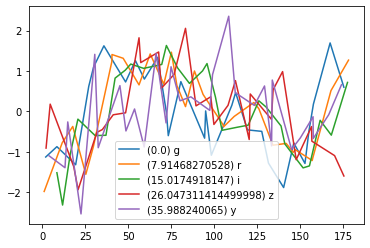

In [10]:
lc.plot_full_lightcure()

In [0]:
objid = agn_cat["obj_id"].unique()

In [0]:
import numpy as np
full_padded_lc = []
for i in objid:
  lc = lightcurve(lc_cad6, agn_cat, i)
  full_padded_lc.append(lc.pad_sequences())

In [0]:
fplc = np.array(full_padded_lc)

In [21]:
import numpy as np

xxx = np.array(pad_lc)

print(xxx.transpose(2,1).shape)

ValueError: ignored

In [26]:
xxx.transpose(0,2,1).shape

(5, 32, 3)

In [0]:
pad_seq = tf.keras.preprocessing.sequence.pad_sequences

In [0]:
def lc_to_padseq(lc):
  

In [0]:
a = lc._lc[["time_g", "f_g"]]

In [110]:
pad_seq(a.values.transpose(), maxlen=32, dtype='double')

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.10000000e+00,
        8.60000000e+00, 1.95000000e+01, 2.71000000e+01, 2.99000000e+01,
        3.59000000e+01, 4.28000000e+01, 4.85000000e+01, 5.42000000e+01,
        5.94000000e+01, 6.71000000e+01, 7.22000000e+01, 7.33000000e+01,
        8.06000000e+01, 9.44000000e+01, 9.50000000e+01, 9.83000000e+01,
        1.10200000e+02, 1.12400000e+02, 1.19300000e+02, 1.27600000e+02,
        1.31500000e+02, 1.40300000e+02, 1.46200000e+02, 1.52700000e+02,
        1.55000000e+02, 1.57600000e+02, 1.67300000e+02, 1.75300000e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.09905153e-13,
        5.10801347e-13, 5.09237003e-13, 5.16024293e-13, 5.17692899e-13,
        5.19534139e-13, 5.17813228e-13, 5.16405529e-13, 5.18250807e-13,
        5.16653884e-13, 5.18532578e-13, 5.13781476e-13, 5.11754034e-13,
        5.16432283e-13, 5.11537670e-13, 5.13895093e-13, 5.10058241e-13,
        5.14376611e-13, 5.15483783e-13, 5.12253739e-13, 5.12125

In [0]:
xxx = pad_seq([a["f_g"].values, a["f_g"].values], maxlen=32, dtype='double')

In [100]:
xxx.shape

(2, 32)

In [101]:
xxx[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.09905153e-13,
       5.10801347e-13, 5.09237003e-13, 5.16024293e-13, 5.17692899e-13,
       5.19534139e-13, 5.17813228e-13, 5.16405529e-13, 5.18250807e-13,
       5.16653884e-13, 5.18532578e-13, 5.13781476e-13, 5.11754034e-13,
       5.16432283e-13, 5.11537670e-13, 5.13895093e-13, 5.10058241e-13,
       5.14376611e-13, 5.15483783e-13, 5.12253739e-13, 5.12125946e-13,
       5.09376528e-13, 5.07260001e-13, 5.11120678e-13, 5.09346686e-13,
       5.12158752e-13, 5.14485954e-13, 5.19782990e-13, 5.15946635e-13])